In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models

In [ ]:
!nvidia-smi

Wed Jul 10 01:22:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomCrop((256,256),pad_if_needed=True),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.OxfordIIITPet("pets_data/","trainval",transform=transform,download=True)
test_dataset = torchvision.datasets.OxfordIIITPet("pets_data/","test",transform=transform,download=True)

100%|██████████| 791918971/791918971 [00:45<00:00, 17558646.10it/s]


Extracting pets_data/oxford-iiit-pet/images.tar.gz to pets_data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8646644.32it/s] 


Extracting pets_data/oxford-iiit-pet/annotations.tar.gz to pets_data/oxford-iiit-pet


In [ ]:
# Create different networks for evaluation

class NetworkA(nn.Module):
    def __init__(self):
        super(NetworkA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(256*32*32, 1024)
        self.fc2 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.ReLU(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.ReLU(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

class NetworkB(nn.Module):
    def __init__(self):
        super(NetworkB, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(256*32*32, 1024)
        self.fc2 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.conv1(x))
        x = self.ReLU(self.conv2(x))
        x = self.pool1(x)
        x = self.ReLU(self.conv3(x))
        x = self.ReLU(self.conv4(x))
        x = self.pool2(x)
        x = self.ReLU(self.conv5(x))
        x = self.ReLU(self.conv6(x))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

class NetworkC(nn.Module):
    def __init__(self):
        super(NetworkC, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(512*16*16, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.conv1(x))
        x = self.pool1(x)
        x = self.ReLU(self.conv2(x))
        x = self.pool2(x)
        x = self.ReLU(self.conv3(x))
        x = self.pool3(x)
        x = self.ReLU(self.conv4(x))
        x = self.pool4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.ReLU(self.fc1(x))
        x = self.dropout1(x)
        x = self.ReLU(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Function to train the model
def train_model(model, train_loader, learning_rate, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.CrossEntropyLoss()
    model.to(device)
    scaler = torch.cuda.amp.GradScaler()
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output = model(images)
                loss = loss_func(output, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    training_time = time.time() - start_time
    return training_time

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0
    model.to(device)
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    testing_time = time.time() - start_time
    return accuracy, testing_time

In [ ]:
# Experiment settings
learning_rates = [1e-3, 1e-4, 1e-5]
batch_sizes = [8, 16, 32]
num_epochs_list = [1, 3]
results = []

In [ ]:
# Train and evaluate each model with different learning rates and batch sizes
for i, Network in enumerate([NetworkA, NetworkB, NetworkC], 1):
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for num_epochs in num_epochs_list:
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                model = Network()
                print(f"Training Network {i} with learning rate {lr} batch size {batch_size} and epochs {num_epochs}")
                training_time = train_model(model, train_loader, learning_rate=lr, num_epochs=num_epochs, device=device)
                accuracy, testing_time = evaluate_model(model, test_loader, device=device)
                results.append({
                    'Network': f'Network{i}',
                    'Learning Rate': lr,
                    'Batch Size': batch_size,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy,
                    'Training Time (s)': training_time,
                    'Testing Time (s)': testing_time
                })
                print(f"Network {i}, Learning Rate {lr}, Batch Size {batch_size}, Epochs {num_epochs}, Accuracy: {accuracy:.2f}%, Training Time: {training_time:.2f}s, Testing Time: {testing_time:.2f}s")

# Display results
results_df = pd.DataFrame(results)
print(results_df)

Training Network 1 with learning rate 0.001 batch size 8 and epochs 1
Epoch 1/1
Network 1, Learning Rate 0.001, Batch Size 8, Epochs 1, Accuracy: 2.75%, Training Time: 19.47s, Testing Time: 15.25s
Training Network 1 with learning rate 0.001 batch size 8 and epochs 3
Epoch 1/3
Epoch 2/3
Epoch 3/3
Network 1, Learning Rate 0.001, Batch Size 8, Epochs 3, Accuracy: 2.75%, Training Time: 58.69s, Testing Time: 15.55s
Training Network 1 with learning rate 0.001 batch size 16 and epochs 1
Epoch 1/1
Network 1, Learning Rate 0.001, Batch Size 16, Epochs 1, Accuracy: 2.73%, Training Time: 17.79s, Testing Time: 15.14s
Training Network 1 with learning rate 0.001 batch size 16 and epochs 3
Epoch 1/3
Epoch 2/3
Epoch 3/3
Network 1, Learning Rate 0.001, Batch Size 16, Epochs 3, Accuracy: 2.75%, Training Time: 53.16s, Testing Time: 14.75s
Training Network 1 with learning rate 0.001 batch size 32 and epochs 1
Epoch 1/1
Network 1, Learning Rate 0.001, Batch Size 32, Epochs 1, Accuracy: 2.78%, Training Time

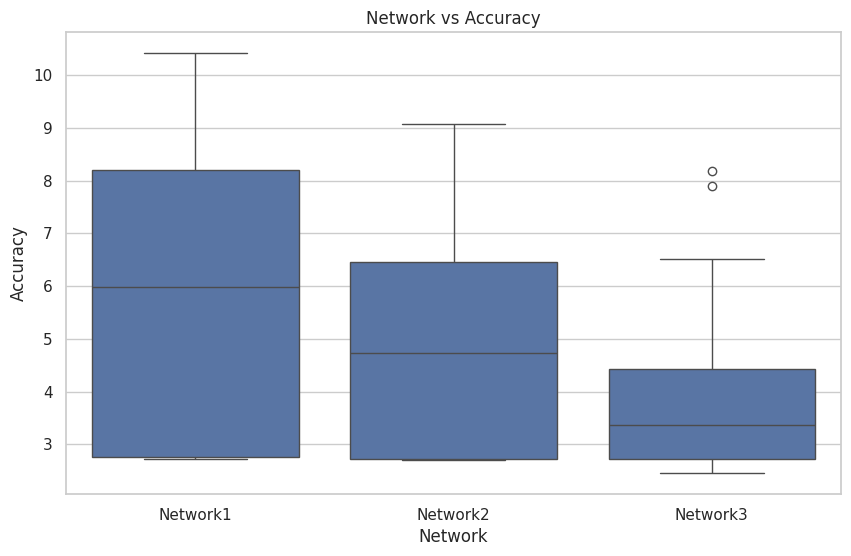

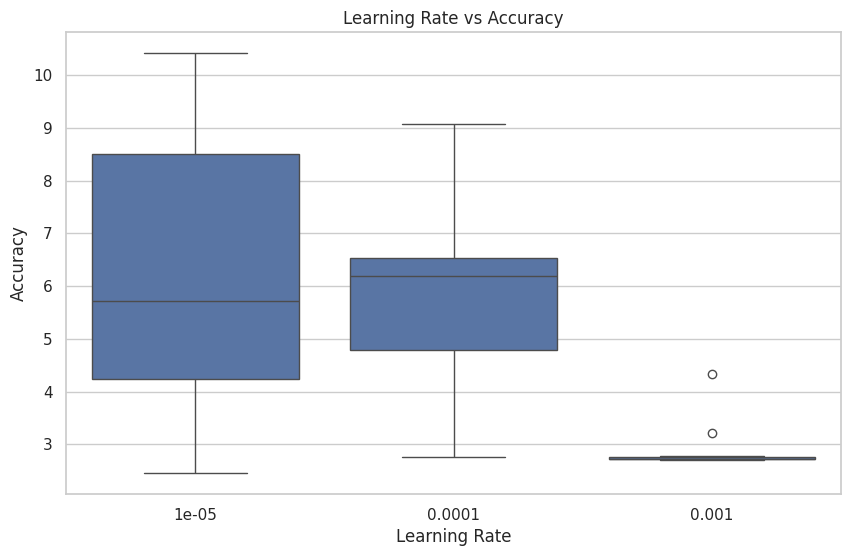

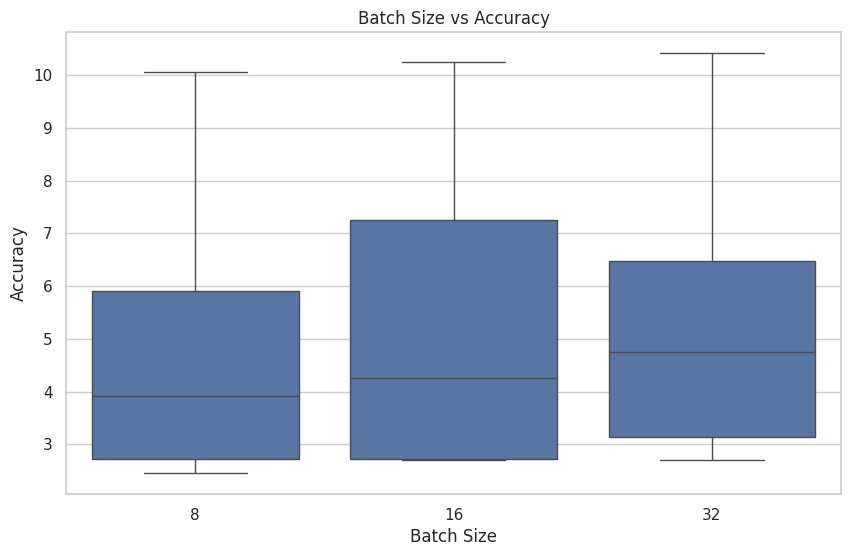

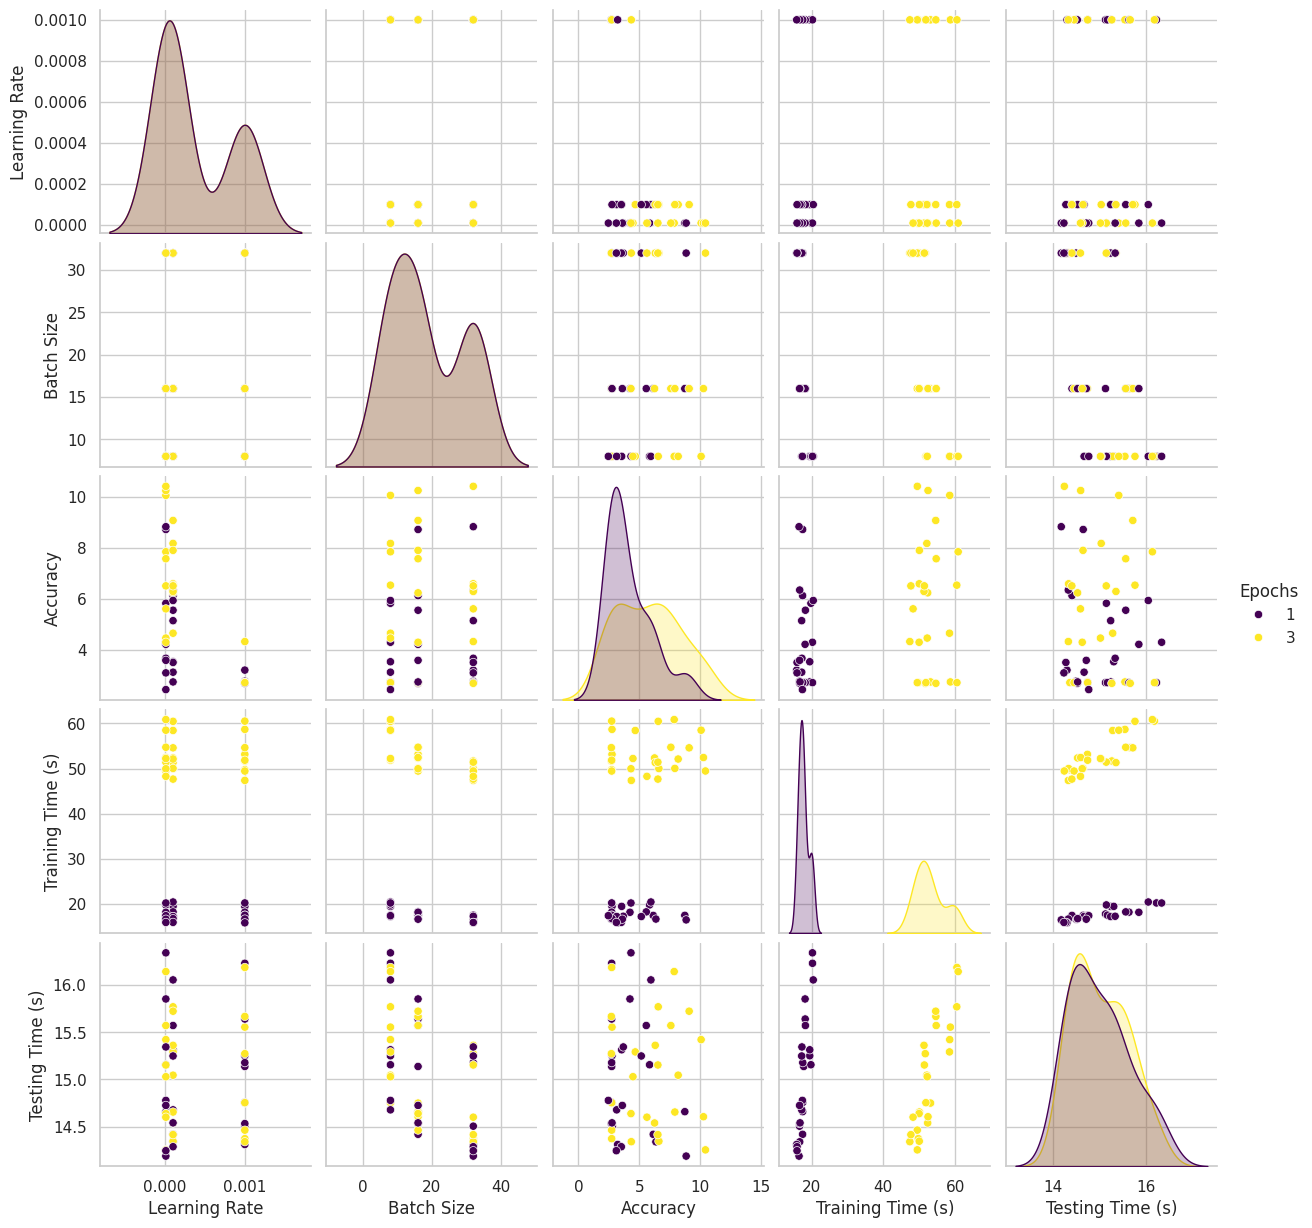

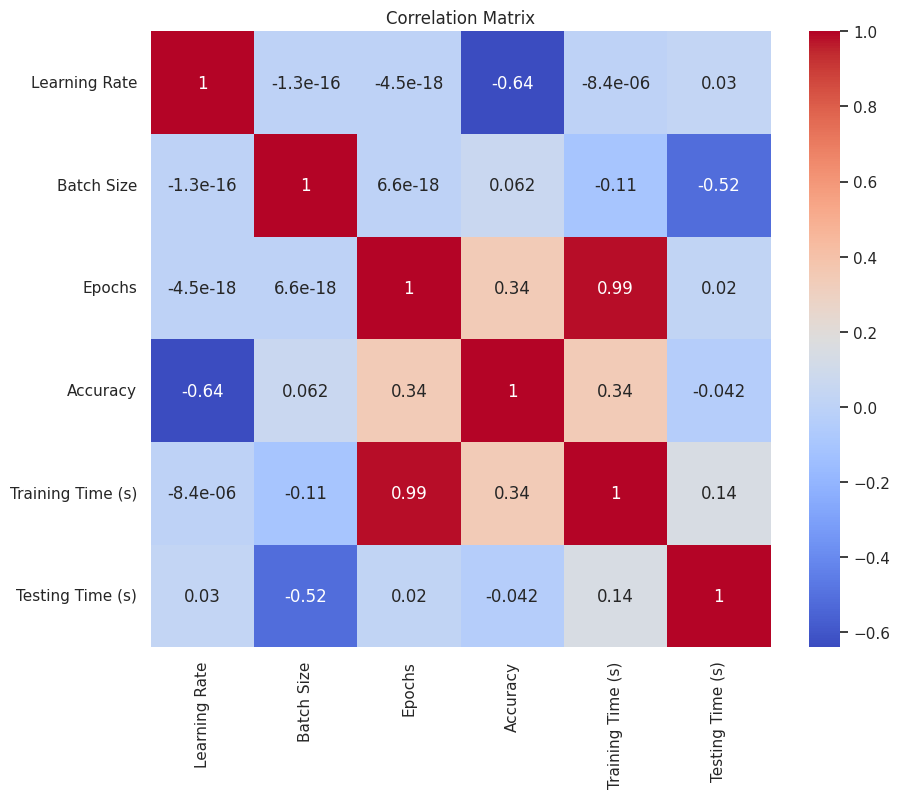

In [ ]:
# Visualization
sns.set(style="whitegrid")

# Network vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Network', y='Accuracy', data=results_df)
plt.title('Network vs Accuracy')
plt.show()

# Learning Rate vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Learning Rate', y='Accuracy', data=results_df)
plt.title('Learning Rate vs Accuracy')
plt.show()

# Batch Size vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Batch Size', y='Accuracy', data=results_df)
plt.title('Batch Size vs Accuracy')
plt.show()

# Pairplot to see correlations
sns.pairplot(results_df.drop(columns=['Network']), hue='Epochs', palette='viridis')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = results_df.drop(columns=['Network']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
class NetworkA2(nn.Module):
    def __init__(self):
        super(NetworkA2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(256*32*32, 1024)
        self.fc2 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.ReLU(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.ReLU(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class NetworkB2(nn.Module):
    def __init__(self):
        super(NetworkB2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(256*32*32, 1024)
        self.fc2 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.bn1(self.conv1(x)))
        x = self.ReLU(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.ReLU(self.bn3(self.conv3(x)))
        x = self.ReLU(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.ReLU(self.bn5(self.conv5(x)))
        x = self.ReLU(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class NetworkC2(nn.Module):
    def __init__(self):
        super(NetworkC2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512*16*16, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 37)

    def forward(self, x):
        x = self.ReLU(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.ReLU(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.ReLU(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.ReLU(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.ReLU(self.fc1(x))
        x = self.dropout(x)
        x = self.ReLU(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Utilize pre-trained models such as ResNet to fine-tune them on your dataset.
class FineTunedResNet(nn.Module):
    def __init__(self):
        super(FineTunedResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 37)  # Assuming 37 classes according to the internet

    def forward(self, x):
        return self.model(x)

In [ ]:
# Function to train the model
def train_model2(model, train_loader, learning_rate, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    loss_func = torch.nn.CrossEntropyLoss()
    model.to(device)
    scaler = torch.cuda.amp.GradScaler()
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output = model(images)
                loss = loss_func(output, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

    training_time = time.time() - start_time
    return training_time

In [ ]:
# Function to evaluate the model
def evaluate_model2(model, test_loader, device):
    correct = 0
    total = 0
    model.to(device)
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    testing_time = time.time() - start_time
    return accuracy, testing_time

In [ ]:
# Experiment settings
learning_rates2 = [1e-3, 1e-4, 1e-5]
batch_sizes2 = [8, 16, 32]
num_epochs_list2 = [10, 20]
results2 = []

In [ ]:
# Train and evaluate each model with different learning rates, batch sizes, and number of epochs
for i, Network in enumerate([NetworkA2, NetworkB2, NetworkC2, FineTunedResNet], 1):
    for lr in learning_rates2:
        for batch_size in batch_sizes2:
            for num_epochs in num_epochs_list2:
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                model = Network()
                print(f"Training Network {i} with learning rate {lr}, batch size {batch_size}, and epochs {num_epochs}")
                training_time = train_model2(model, train_loader, learning_rate=lr, num_epochs=num_epochs, device=device)
                accuracy, testing_time = evaluate_model(model, test_loader, device=device)
                results2.append({
                    'Network': f'Network{i}',
                    'Learning Rate': lr,
                    'Batch Size': batch_size,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy,
                    'Training Time (s)': training_time,
                    'Testing Time (s)': testing_time
                })
                print(f"Network {i}, Learning Rate {lr}, Batch Size {batch_size}, Epochs {num_epochs}, Accuracy: {accuracy:.2f}%, Training Time: {training_time:.2f}s, Testing Time: {testing_time:.2f}s")

# Convert results to DataFrame
results2_df = pd.DataFrame(results2)

# Display results
print(results2_df)

Training Network 1 with learning rate 0.001, batch size 8, and epochs 10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Network 1, Learning Rate 0.001, Batch Size 8, Epochs 10, Accuracy: 2.67%, Training Time: 194.77s, Testing Time: 15.15s
Training Network 1 with learning rate 0.001, batch size 8, and epochs 20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Network 1, Learning Rate 0.001, Batch Size 8, Epochs 20, Accuracy: 3.11%, Training Time: 390.81s, Testing Time: 15.34s
Training Network 1 with learning rate 0.001, batch size 16, and epochs 10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Network 1, Learning Rate 0.001, Batch Size 16, Epochs 10, Accuracy: 2.73%, Training Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Training Network 4 with learning rate 0.001, batch size 8, and epochs 10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Network 4, Learning Rate 0.001, Batch Size 8, Epochs 10, Accuracy: 18.04%, Training Time: 265.83s, Testing Time: 16.89s
Training Network 4 with learning rate 0.001, batch size 8, and epochs 20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Network 4, Learning Rate 0.001, Batch Size 8, Epochs 20, Accuracy: 27.96%, Training Time: 540.70s, Testing Time: 16.85s
Training Network 4 with learning rate 0.001, batch size 16, and epochs 10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Network 4, Learning Rate 0.001, Batch Size 16, Epochs 10, Accuracy: 41.32%, Training Ti

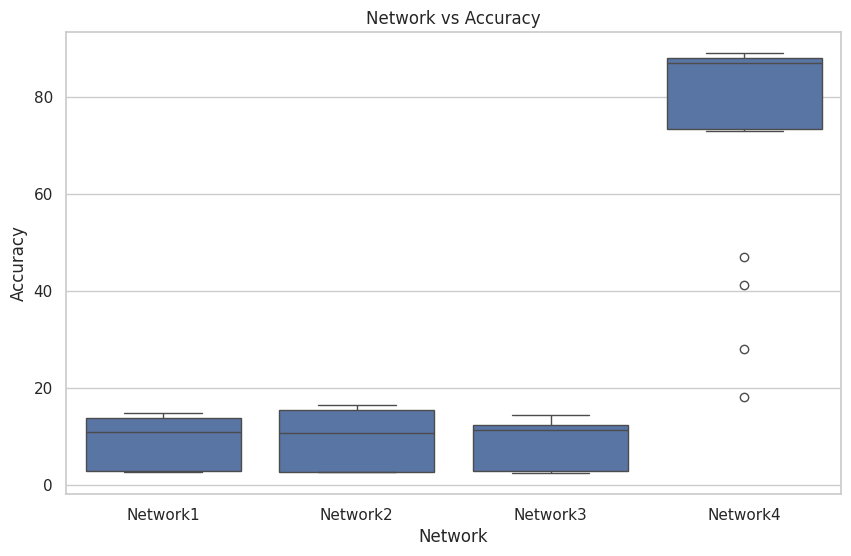

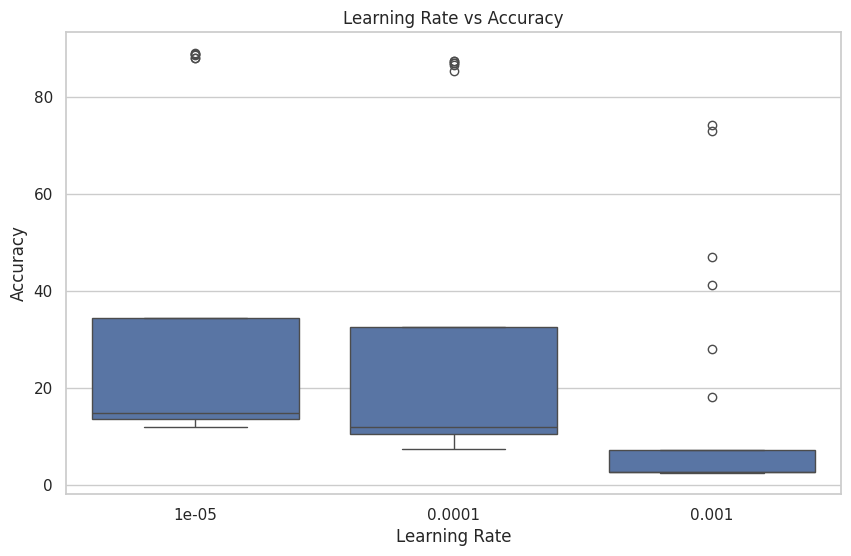

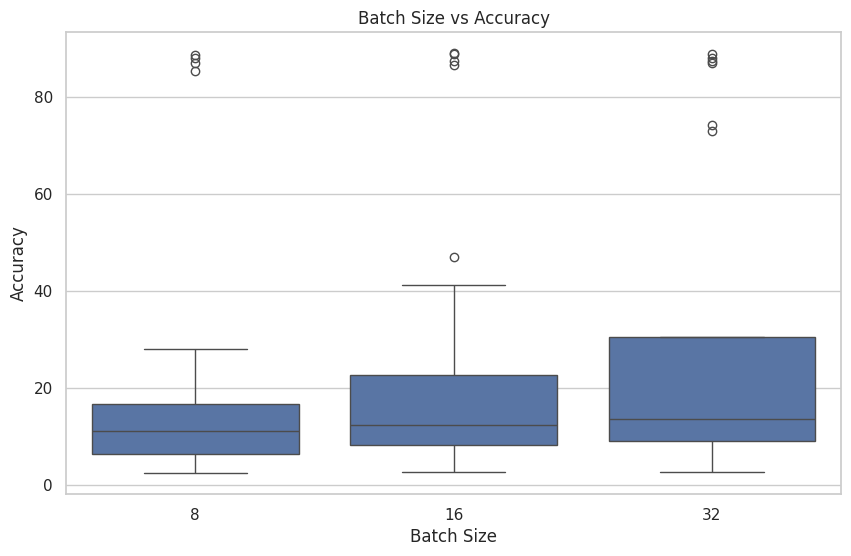

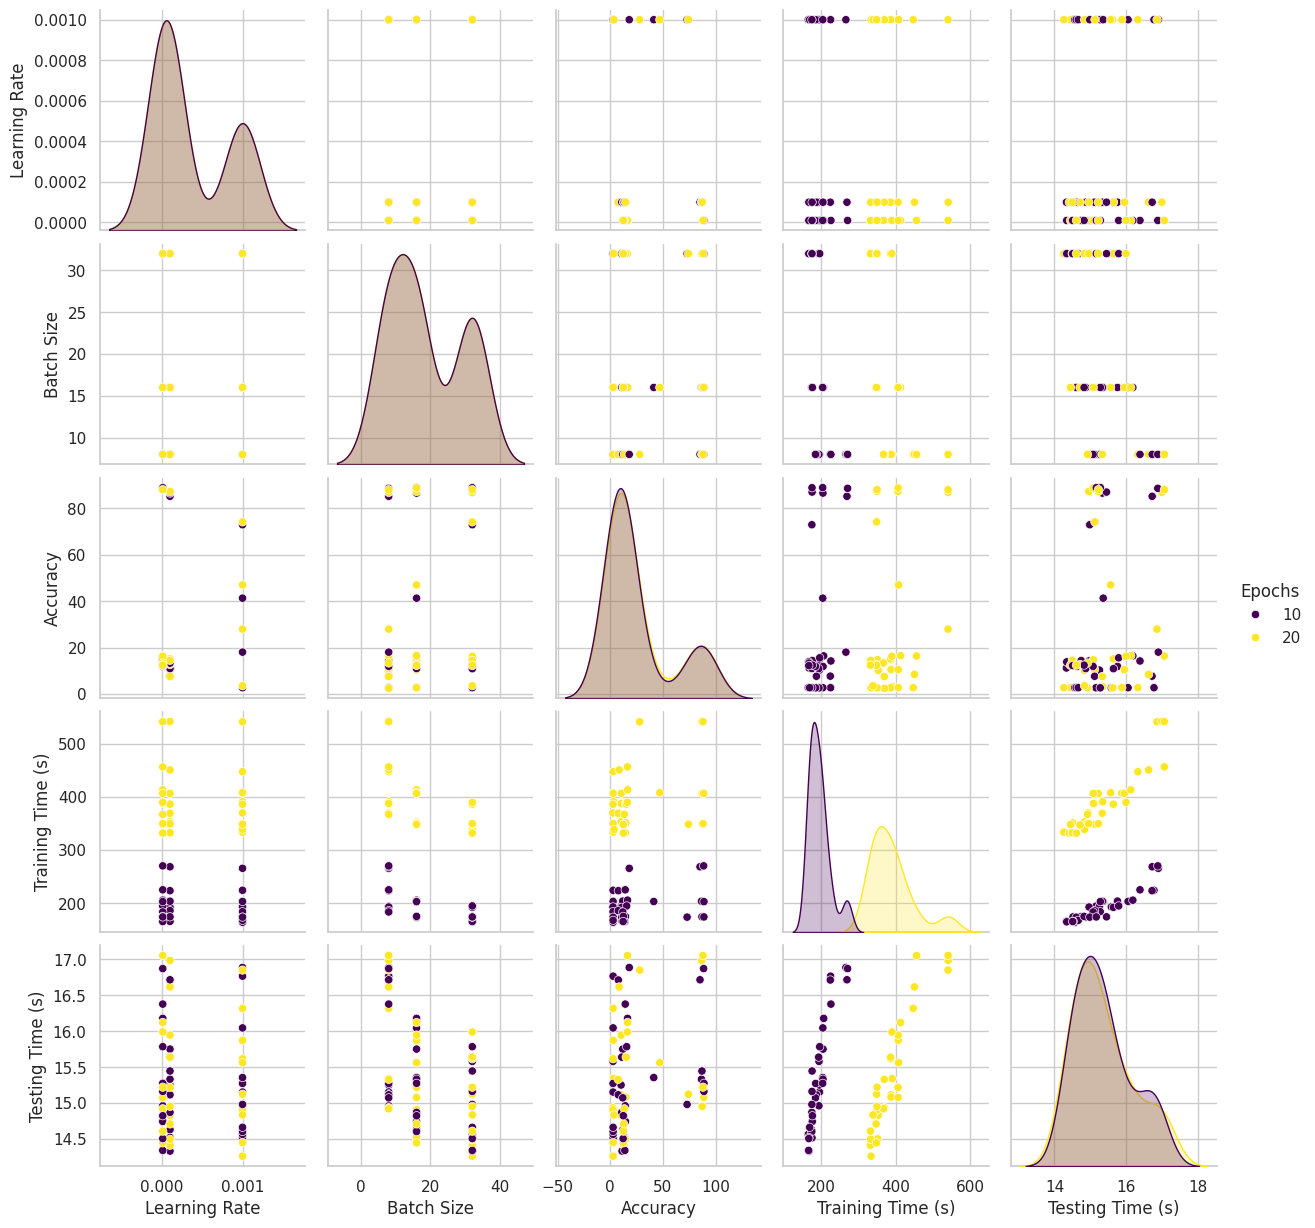

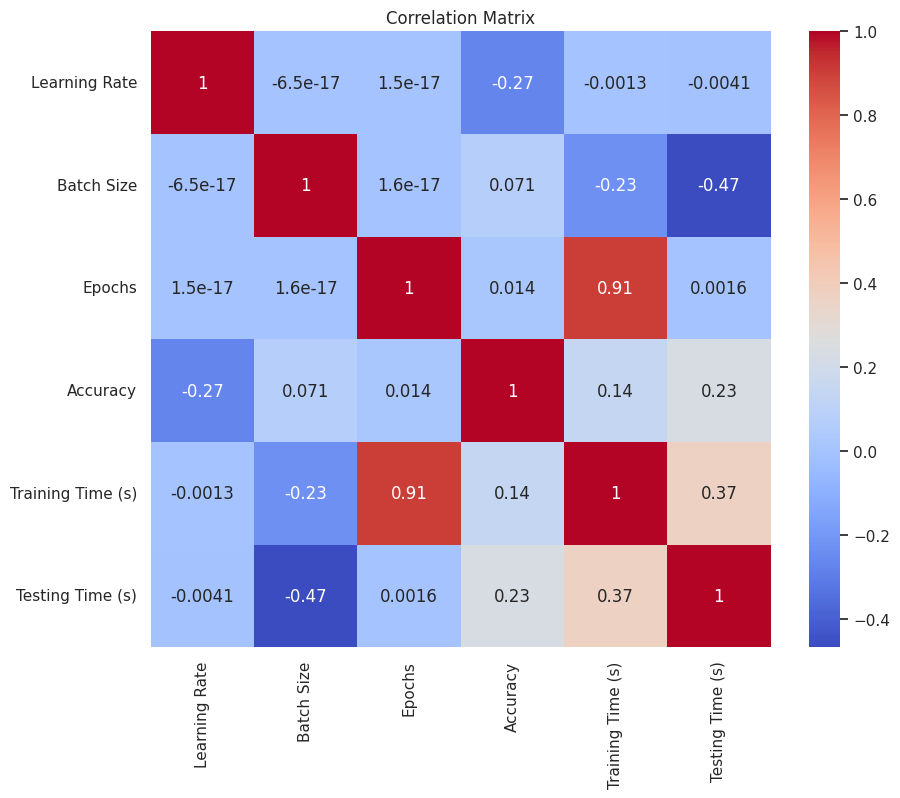

In [ ]:
# Visualization
sns.set(style="whitegrid")

# Network vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Network', y='Accuracy', data=results2_df)
plt.title('Network vs Accuracy')
plt.show()

# Learning Rate vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Learning Rate', y='Accuracy', data=results2_df)
plt.title('Learning Rate vs Accuracy')
plt.show()

# Batch Size vs Accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x='Batch Size', y='Accuracy', data=results2_df)
plt.title('Batch Size vs Accuracy')
plt.show()

# Pairplot to see correlations
sns.pairplot(results2_df.drop(columns=['Network']), hue='Epochs', palette='viridis')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = results2_df.drop(columns=['Network']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Unsuprising, the pre-trained network performed exceptionally well compared to the other networks, despite trying to increase their complexity. When looking at the correlation heatmap, there are strong correlationswith epochs and training time. Accuracy generally increased with batch size, but would also drive town training time. Accuracy generally descreased as learning rate increased, again unsurprising.

With more time and with resources less of an issue, it would have been worthwhile to increase the batch size, epochs, and decrease the learning rate. These changes are ultimately lower in priority compared to just the network itself. Despite trying to increase the complexity, change layers, and add dropouts, none of the manually coded networks performed particularly well or did better with modification.